**Project Scope:** In this project we will use coordinate data captured from various hand gestures to build a classifier that is able to properly predict which hand gesture is being presented. A simple use case or extension of this model might be identifying gestures for computer vision. 

Original Data Source: 
https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures

In [1]:
#Importing Dependencies 
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#data transformation and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from scipy import stats
from scipy.stats.mstats import winsorize
import math
import statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

**Data Cleaning**

We will start by importing our data from a csv and doing some basic cleaning. In the cell below we drop categories that were specified as empty by the author, we replace question marks with NaN, we change some data types and we create a copy of our original data as a precaution.

In [2]:
#importing data
df = pd.read_csv('postures.csv')

#dropping empty category (accoding to data author)
df.drop(df[df['User'] == 0].index, inplace=True)

#replacing questionmarks 
df = df.replace('?', np.NaN)

#converting data type
df = df.astype(float)

#dropping X11, Y11, Z11 because they are near empty
df.drop(['X11', 'Y11', 'Z11'], axis=1, inplace=True)

#saving copy of formatted dataframe
df_cpy = df.copy()

#examining the shape of the data
df.shape

(69047, 35)

In [3]:
#we can examine the head of the data in its current state
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
9049,1.0,1.0,29.699315,86.235155,-50.412865,10.640074,84.263077,-44.484302,53.356216,82.914148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9050,1.0,1.0,29.744358,85.954124,-50.094668,10.739796,84.043944,-44.134900,53.374626,82.571797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9051,1.0,1.0,29.713936,85.950764,-49.606704,10.628119,84.095152,-43.928478,53.496711,82.573430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9052,1.0,1.0,29.712018,85.967603,-49.239333,10.550590,84.123348,-43.922002,53.672679,82.547662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9053,1.0,1.0,30.430470,85.626083,-48.860555,10.997782,84.049843,-44.259520,54.588424,82.366638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we shift our coordinate space by adding 168 to our data, making it positive, allowing for easier transformation later. Note, because of the equivalent scale, this does not impact our values. 

In [4]:
#shifting coordinates into positive plane by adding smallest value to all coordinate values
coord_cols = df.columns[2:]

for i in coord_cols:
    df[i] = df[i] + 168

To make things easier to follow we will add a column with the decriptive name of the class to reflect which gesture they represent. 

In [5]:
#adding description column based on class column
name_list = ['Thumb_up', 'Stop', 'Point', 'Peace', 'Grab']

#indexing from 1 because 1 corresponds to our first class 'Thumb_up' in the data
class_number = 1

#looping through descriptive names and adding description column based on provided class number
for name in name_list:
    df.loc[df['Class'] == class_number, 'description' ] = name_list[class_number-1]
    class_number += 1

In [6]:
#examining our data after making the above changes 
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10,description
9049,1.0,1.0,197.699315,254.235155,117.587135,178.640074,252.263077,123.515698,221.356216,250.914148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thumb_up
9050,1.0,1.0,197.744358,253.954124,117.905332,178.739796,252.043944,123.865100,221.374626,250.571797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thumb_up
9051,1.0,1.0,197.713936,253.950764,118.393296,178.628119,252.095152,124.071522,221.496711,250.573430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thumb_up
9052,1.0,1.0,197.712018,253.967603,118.760667,178.550590,252.123348,124.077998,221.672679,250.547662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thumb_up
9053,1.0,1.0,198.430470,253.626083,119.139445,178.997782,252.049843,123.740480,222.588424,250.366638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thumb_up


**Data Exploration**

We can see in the left plot below that there is an imbalance with respect to users. Some people recorded many more entries than others. We do not have information about the people who made these recordings, nor about their hand sizes. For now we will assume this imbalance will not affect our classfication, but it may be something to address if we find that our model is facing performance issues. 

In the right plot we can see that there is at least 12,000 entries for each of the gestures. This is good because it shows us that there is no imbalance with respect to the target we are trying to predict. There is a relatively balanced and representative set of data avaiable to train our model with. 

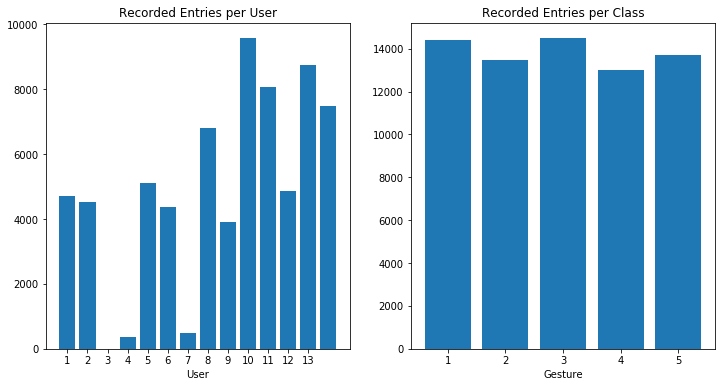

User
1.0     4717
2.0     4513
4.0      379
5.0     5105
6.0     4377
7.0      492
8.0     6811
9.0     3920
10.0    9573
11.0    8061
12.0    4865
13.0    8739
14.0    7495
Name: Class, dtype: int64
---------
Class
1.0    14393
2.0    13477
3.0    14493
4.0    12994
5.0    13690
Name: User, dtype: int64


In [7]:
#Counting the available data for each user 
user_count = df.groupby('User').agg('count')['Class']

#Counting the available data for each hand gesture
class_count = df.groupby('Class').agg('count')['User']

#Plotting bar graph to compare recorded entries per user
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(user_count.index, user_count)
plt.title('Recorded Entries per User')
plt.xlabel('User')
plt.xticks(np.arange(1,14, step=1))

#Plotting bar graph to compare amount of entries per class 
plt.subplot(1,2,2)
plt.bar(class_count.index, class_count)
plt.title('Recorded Entries per Class')
plt.xlabel('Gesture')
plt.xticks(np.arange(1,6, step=1))
plt.show()

print(user_count)
print('---------')
print(class_count)

We further can examine the specifics of our data below. 

In [8]:
df.describe()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
count,69047.000000,69047.000000,69047.000000,69047.000000,69047.000000,69047.000000,69047.000000,69047.000000,69047.000000,69047.000000,...,35302.000000,27437.000000,27437.000000,27437.000000,21126.000000,21126.000000,21126.000000,12250.000000,12250.000000,12250.000000
mean,2.972642,9.002216,218.702247,255.676595,141.264256,217.939790,255.004127,141.289056,216.863221,251.820923,...,147.313499,215.836455,252.261012,142.820556,223.142818,245.854536,138.602960,222.815655,236.142718,135.974787
std,1.417586,3.946079,33.183436,39.962858,33.067949,32.938346,40.353751,33.704407,34.088372,41.063648,...,33.489036,39.246279,42.037108,35.451549,40.958337,42.894983,35.685049,39.626384,41.952339,39.108044
min,1.000000,1.000000,69.526692,69.766244,41.229128,61.997596,92.429068,1.993162,61.113476,103.169658,...,54.266895,68.315100,102.922450,25.345503,68.768312,103.265716,54.602673,87.803711,102.980705,55.331070
25%,2.000000,6.000000,197.204981,236.407288,115.824473,196.218219,234.791756,114.058011,192.251515,227.209452,...,122.097612,183.921149,216.861487,114.730948,194.426857,210.101123,111.016502,188.397645,204.730309,103.768611
50%,3.000000,10.000000,222.418837,255.580583,140.975437,222.132400,255.973254,141.689919,221.732478,254.357253,...,147.952431,222.967913,257.059479,144.638557,230.189925,247.904859,138.891714,230.591304,231.595304,131.099291
75%,4.000000,12.000000,241.213087,289.023203,168.348229,240.354606,286.510396,169.183337,239.909898,274.213021,...,173.962256,248.543466,289.038840,174.077879,252.957739,275.133156,168.613821,252.169926,263.329738,172.917462
max,5.000000,14.000000,331.329840,334.720043,281.345119,333.975416,335.018577,272.697852,331.547310,334.714494,...,279.084692,341.906643,334.264909,275.430658,342.054403,334.553225,291.380512,317.486224,334.064358,276.455548


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69047 entries, 9049 to 78095
Data columns (total 36 columns):
Class          69047 non-null float64
User           69047 non-null float64
X0             69047 non-null float64
Y0             69047 non-null float64
Z0             69047 non-null float64
X1             69047 non-null float64
Y1             69047 non-null float64
Z1             69047 non-null float64
X2             69047 non-null float64
Y2             69047 non-null float64
Z2             69047 non-null float64
X3             68594 non-null float64
Y3             68594 non-null float64
Z3             68594 non-null float64
X4             66584 non-null float64
Y4             66584 non-null float64
Z4             66584 non-null float64
X5             59219 non-null float64
Y5             59219 non-null float64
Z5             59219 non-null float64
X6             47291 non-null float64
Y6             47291 non-null float64
Z6             47291 non-null float64
X7            

To start visually exploring our data we can use boxenplots to examine how the distribution of our data changes based on the gesture that is being made. We can do this any compare every coordinate channel to see that there are notable differences between every gesture. The plots below serve only to show that there is a clear difference between each gesture that can be used to help us classify new gestures after training based on some of these differences.

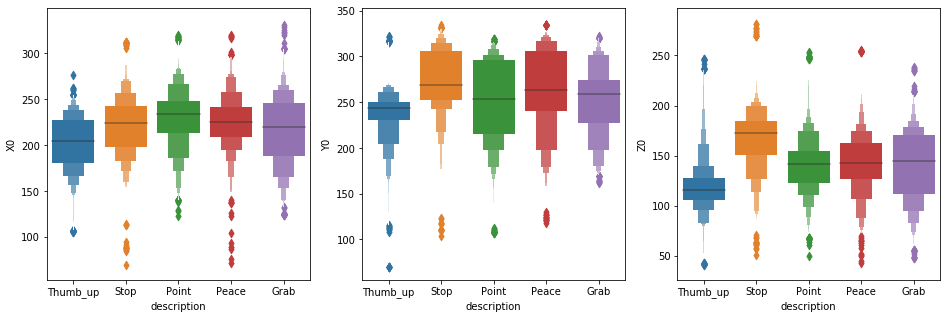

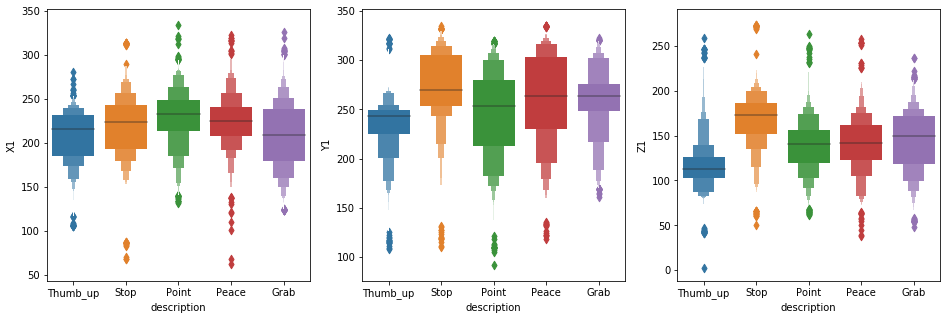

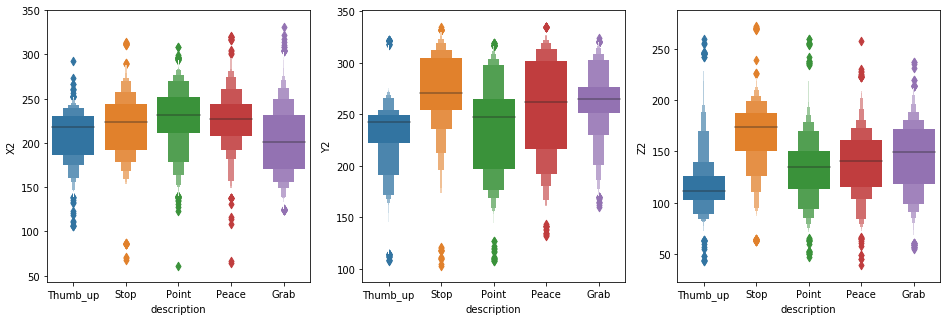

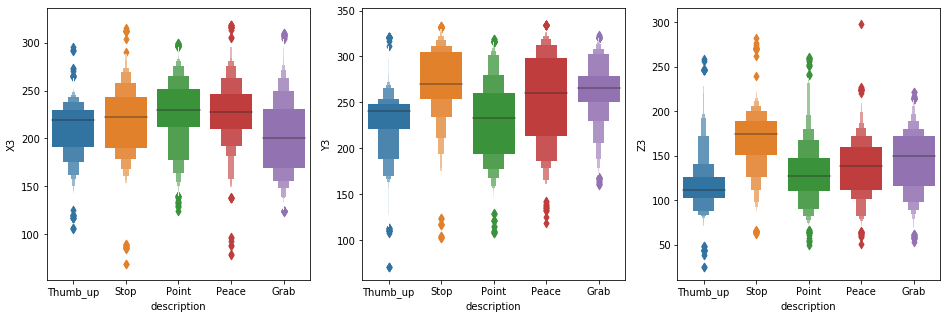

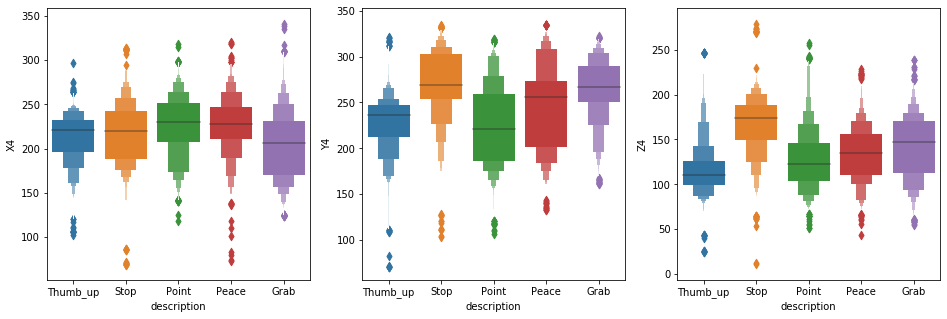

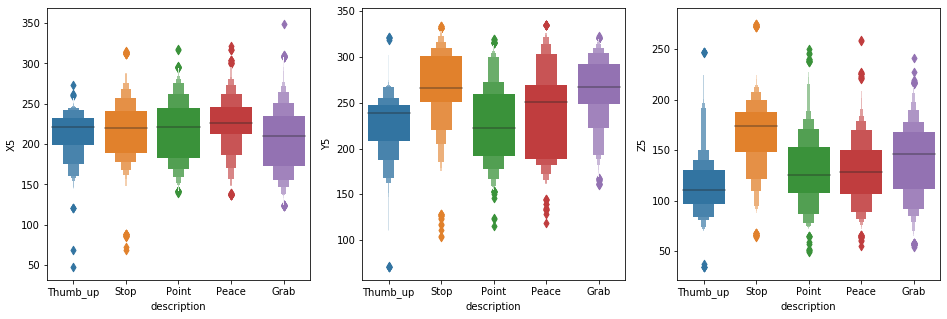

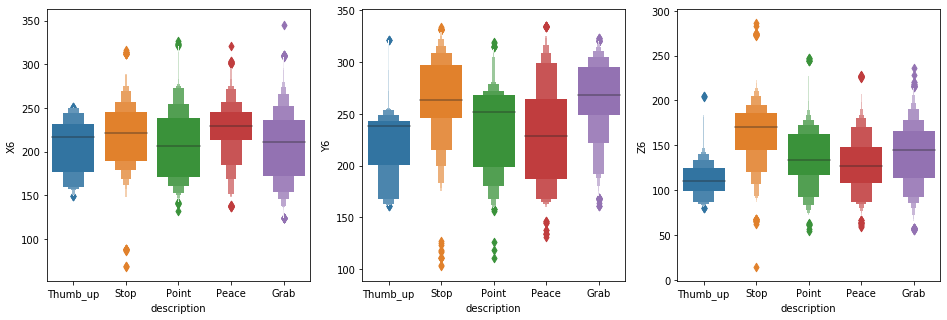

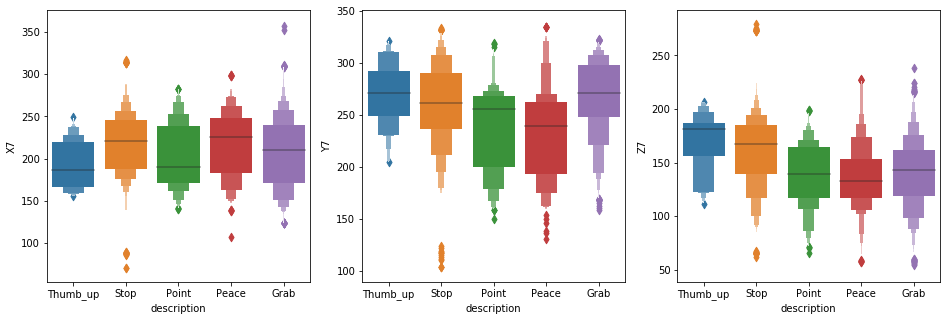

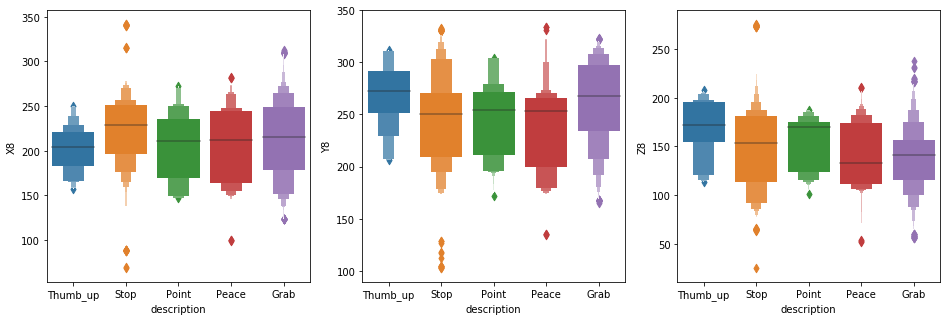

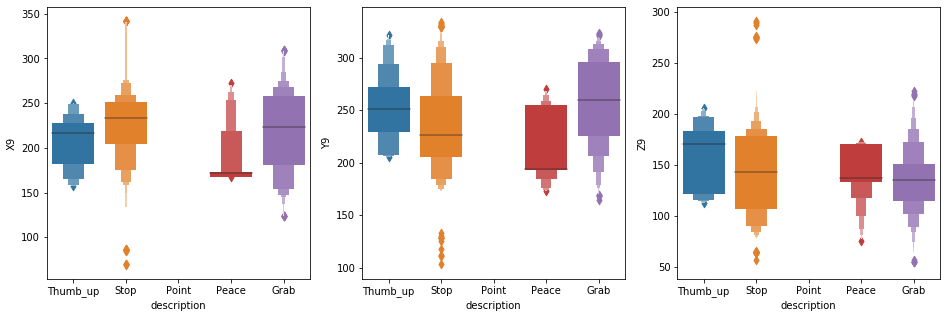

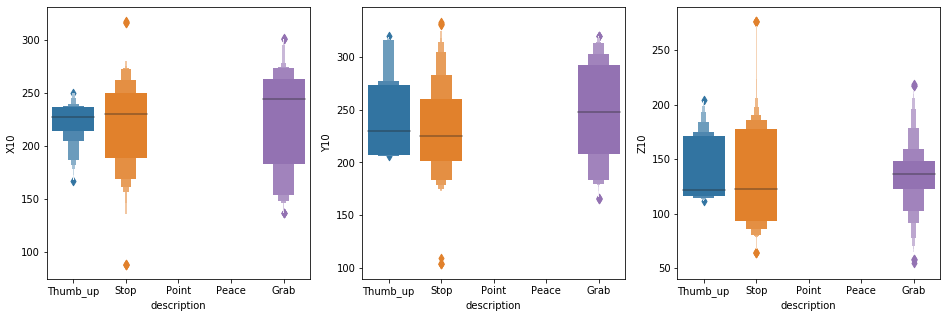

In [10]:
for i in range(11):
    plt.figure(figsize=(16,5))
    plt.subplot(1,3,1)
    sns.boxenplot(x='description', y='X'+str(i), data=df)
    plt.subplot(1,3,2)
    sns.boxenplot(x='description', y='Y'+str(i), data=df)
    plt.subplot(1,3,3)
    sns.boxenplot(x='description', y='Z'+str(i), data=df)
    plt.show()

From the plots above we can see that there are noticable differences in the coordinate distributions for each of gestures that we are trying to classify. We can also see that there are outliers. There are many ways to approach outliers, we can drop them, winsorize them, or transform them. The approach we take here is to perform a log transformation. 

In [11]:
#examining our columns for indexing 
df.columns

Index(['Class', 'User', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2',
       'X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6',
       'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10',
       'Z10', 'description'],
      dtype='object')

In [12]:
#log transforming numerical data to handle outliers
df = pd.concat([df[['Class', 'User', 'description']], np.log(df[df.columns[2:-1]])], axis=1)

df.head()

,Class,User,description,X0,Y0,Z0,X1,Y1,Z1,X2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
9049,1.0,1.0,Thumb_up,5.286747,5.538260,4.767180,5.185373,5.530472,4.816368,5.399773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9050,1.0,1.0,Thumb_up,5.286975,5.537154,4.769882,5.185931,5.529603,4.819193,5.399856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9051,1.0,1.0,Thumb_up,5.286821,5.537140,4.774012,5.185306,5.529807,4.820858,5.400408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9052,1.0,1.0,Thumb_up,5.286812,5.537207,4.777110,5.184872,5.529918,4.820910,5.401202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9053,1.0,1.0,Thumb_up,5.290439,5.535861,4.780295,5.187373,5.529627,4.818186,5.405324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To further explore our data we will first group by our columns and gestures. To start we will isolate our x, y and z columns. 

In [13]:
#isolating columns with coordinate data
numerical_cols = list(df.columns)
numerical_cols.remove('Class')
numerical_cols.remove('User')
numerical_cols.remove('description')

#Order column names by their coordinate term
numerical_cols.sort()

#separate columns by x, y, z coordinate
x_terms = numerical_cols[0:11]
y_terms = numerical_cols[11:22]
z_terms = numerical_cols[22:33]

Next we will group our data by the gesture. 

In [14]:
#grouping data by gesture 
class_1 = df[df['description'] == 'Thumb_up']
class_2 = df[df['description'] == 'Stop']
class_3 = df[df['description'] == 'Point']
class_4 = df[df['description'] == 'Peace']
class_5 = df[df['description'] == 'Grab']

gestures = [class_1, class_2, class_3, class_4, class_5]

To further explore this data we will see how the coordinate data differs between gestures. We will do this by examining the Kernal Density Estimation (KDE) curve of the means of the coordinates for each gesture. The mean is considered because of the high dimensionality of this data. There are 5 gestures, 3 coordinate systems and 10 entries for each coordinate system. We lose a little information, but by examining the difference in means we can observe how the distribution of centrailty is different for various entries in each gesture. 

In the plots below each curve is on an equivalent scale, allowing for easy visual comparison. This allows us to compare the unique features of each gesture. We can see that the shape, location and magnitude of each kde plot is unique and though gestures may be similar there are no two identical fingerprints found below.

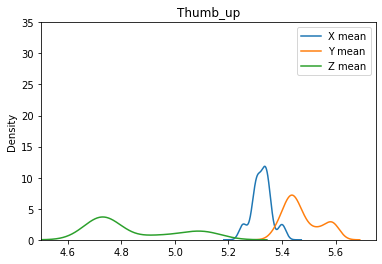

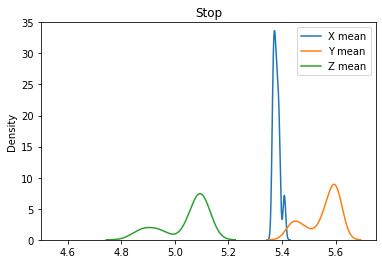

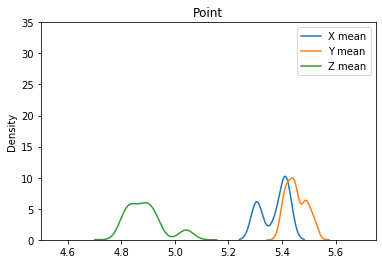

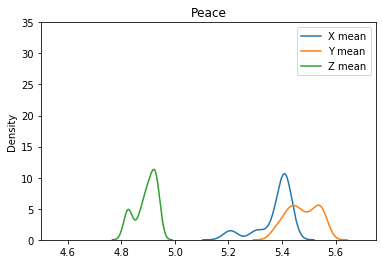

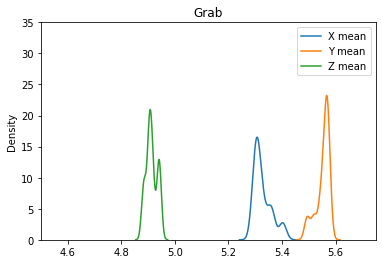

In [15]:
#calculate and examine the distribution of mean values for the coordinates
title = 0

for g in gestures:
    g[x_terms].mean().plot.kde(bw_method=.4)
    g[y_terms].mean().plot.kde(bw_method=.4)
    g[z_terms].mean().plot.kde(bw_method=.4)
    plt.legend(['X mean', 'Y mean', 'Z mean'])
    plt.ylim(0, 35)
    plt.xlim(4.5, 5.75)
    plt.title(name_list[title])
    title +=1
    plt.show()

We can see from the above graphs that each gesture has a unique density profile. We see that some gestures share similarities with others but each has a unique fingerprint that shows that we have clear and meaningful differences between our gesture data that can help us to classify a gesture that we are fed information about.

We can see that the shapes can look pretty similar but scales may differ. We can examine the same data below, instead comparing how the shape of the curve that each class carves in the given coordinate system.

In [16]:
#grouping data by class and term
x_means = df.groupby(by='description').mean()[x_terms]
y_means = df.groupby(by='description').mean()[y_terms]
z_means = df.groupby(by='description').mean()[z_terms]

In [17]:
#reindexing data for plotting
x_df = x_means.T.reindex(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'])
y_df = y_means.T.reindex(['Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10'])
z_df = z_means.T.reindex(['Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10'])

print(x_df)
print('\n')
print(y_df)
print('\n')
print(z_df)

description      Grab     Peace     Point      Stop  Thumb_up
X0           5.354331  5.408438  5.422247  5.390028  5.304916
X1           5.320665  5.407467  5.421486  5.380123  5.331604
X2           5.298556  5.410129  5.411367  5.377593  5.334438
X3           5.294898  5.415178  5.408713  5.373703  5.337986
X4           5.302398  5.413860  5.402514  5.365374  5.349395
X5           5.310387  5.411304  5.370956  5.367103  5.349003
X6           5.310585  5.408871  5.314045  5.372579  5.306696
X7           5.307000  5.367585  5.302522  5.368815  5.254939
X8           5.332363  5.305722  5.301408  5.388529  5.294447
X9           5.364333  5.207718       NaN  5.408661  5.312261
X10          5.402877       NaN       NaN  5.383733  5.399674


description      Grab     Peace     Point      Stop  Thumb_up
Y0           5.518679  5.555961  5.518714  5.605401  5.461697
Y1           5.551708  5.547243  5.491348  5.606558  5.450073
Y2           5.565000  5.533243  5.440621  5.602030  5.441342
Y3    

Above we are examining the mean values by individual marker. It is important to note that in the 9th and 10th position for all three coordinates we find some NaN values. This likely means that this marker was not visible when the coordinate measurement was made. It is important to realize that the NaN value indicates that there were no entries across the 12,000+ rows because this is an aggregate. This means that by doing this gesture the marker was not in view to be measured. Our algorithms might be able to classify based on this missing information. 

We can visualize the information in the tables above to view its differences more intuitaively. 

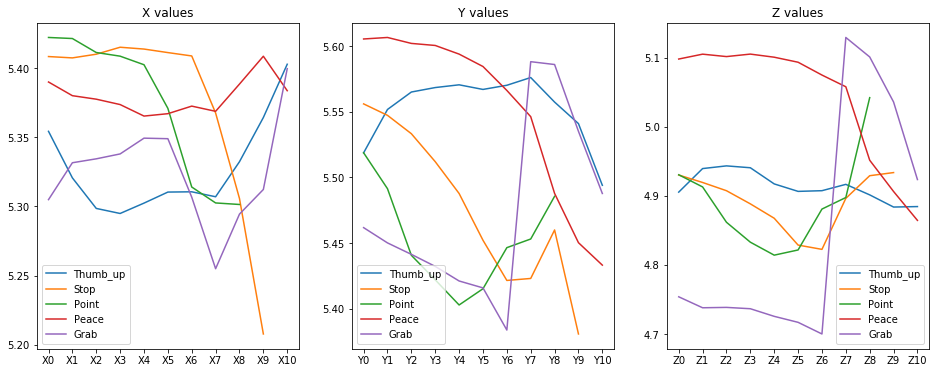

In [18]:
plt.figure(figsize=(16,6))

plt.subplot(1,3,1)
plt.plot(x_df)
plt.title('X values')
plt.legend(name_list)

plt.subplot(1,3,2)
plt.plot(y_df)
plt.title('Y values')
plt.legend(name_list, loc=3)

plt.subplot(1,3,3)
plt.plot(z_df)
plt.title('Z values')
plt.legend(name_list)

plt.show()

**Feature Engineering**

We can examine the data we have to see if there are any highly correlated features. Below we create a correlation matrix to do so. We can see from the visualization that there are many features which are either slrightly positively or negatively correlated with each other. 

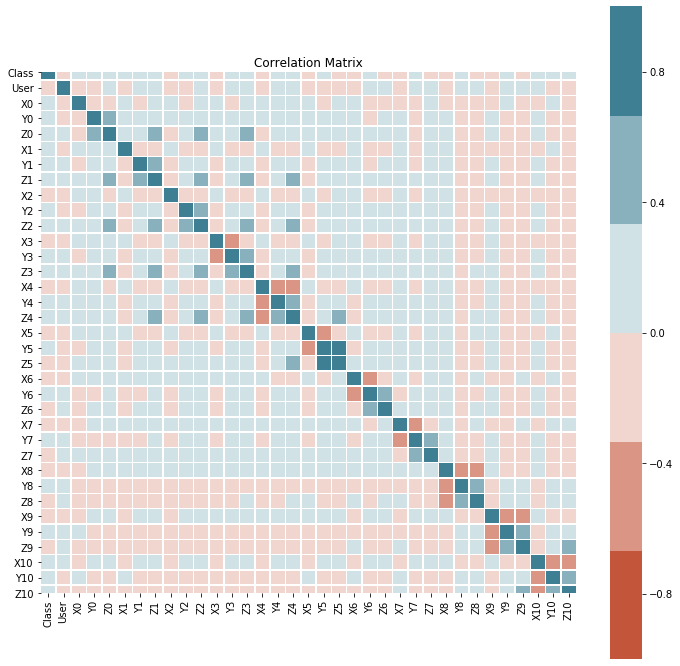

In [19]:
fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(
    df.corr(), 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    vmin=-1,
    vmax=1,
    linewidths=.5).set_title('Correlation Matrix')

One approach we can try is using the mean of the coordinate values for x y and z. This approach is the same as in the KDE plots. We noticed clear differences in our plots, it is worth testing to see if these compounded features will be more correlated with our target variable than their individual components. 

In [20]:
df['X_mean'] = df[x_terms].mean(axis=1)
df['Y_mean'] = df[x_terms].mean(axis=1)
df['Z_mean'] = df[x_terms].mean(axis=1)

We can also set a threshold for which to combine some correlated features. Below the threshold was set at .65 to find some features that might be worth combining. Normally features are combined if they are .8-.9+ correlated. However, here we will do this for the excersize and combine the features that are correlated with each other above this threshold. 

In [21]:
#finding features with atleast 65% correlation in either direction 
corr_matrix = df.corr().abs()

for col in numerical_cols:
    data = corr_matrix[corr_matrix[col] > 0.65]
    if len(data) > 1:
        print('--------')
        print('variable: '+str(col))
        print('correlated with: ' +str(data.index))
    else:
        pass

--------
variable: Y3
correlated with: Index(['Y3', 'Z3'], dtype='object')
--------
variable: Y4
correlated with: Index(['Y4', 'Z4'], dtype='object')
--------
variable: Y5
correlated with: Index(['Y5', 'Z5'], dtype='object')
--------
variable: Y6
correlated with: Index(['Y6', 'Z6'], dtype='object')
--------
variable: Z3
correlated with: Index(['Y3', 'Z3'], dtype='object')
--------
variable: Z4
correlated with: Index(['Y4', 'Z4'], dtype='object')
--------
variable: Z5
correlated with: Index(['Y5', 'Z5'], dtype='object')
--------
variable: Z6
correlated with: Index(['Y6', 'Z6'], dtype='object')


In [22]:
#combining features that achieve at least .65 correlation 
df['Y_Z_3'] = df['Y3'] * df['Z3']
df['Y_Z_4'] = df['Y4'] * df['Z4']
df['Y_Z_5'] = df['Y5'] * df['Z5']
df['Y_Z_6'] = df['Y6'] * df['Z6']

Below we can examine the magnitude of the most correlated features with our target variable. We can see that the most correlation comes from Z7 and Y9. Interestingly, Y9 is one of the values we observed earlier with missing values for the point gesture. This likely has to do with this high score. 

In [23]:
abs(df.corr())['Class'].sort_values(ascending=False)

Class     1.000000
Z7        0.253787
Y9        0.250780
Y8        0.176626
Y2        0.150580
Y3        0.150446
Y4        0.148280
Y10       0.147209
X8        0.144851
Z6        0.144711
Y_Z_3     0.134694
Z1        0.132508
Z2        0.128525
Y1        0.126296
X7        0.118932
Y_Z_4     0.110215
X9        0.109566
Z3        0.107859
X0        0.107767
Y5        0.103876
Z8        0.091878
Z0        0.087219
Y_Z_6     0.079238
Z4        0.073632
Y0        0.060289
Y6        0.050408
Y7        0.049133
X6        0.044272
X5        0.043623
Z9        0.043260
X4        0.042935
X10       0.042326
X3        0.039070
Y_Z_5     0.038907
X2        0.032244
Z10       0.028280
User      0.023542
X_mean    0.019035
Y_mean    0.019035
Z_mean    0.019035
X1        0.006991
Z5        0.001914
Name: Class, dtype: float64

Unfortunately, combining our variables did not result in significant improvement over the original variables. Another approach we can try is Principal Component Analysis (PCA) which will allow us to shrink our feature space while preserving as much variance as possible. 

In [24]:
#columns used for PCA
df.columns[3:]

Index(['X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3',
       'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7',
       'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X_mean',
       'Y_mean', 'Z_mean', 'Y_Z_3', 'Y_Z_4', 'Y_Z_5', 'Y_Z_6'],
      dtype='object')

In [25]:
#selecting df of columns we need for PCA 
pca_df = df[df.columns[3:]].copy()

#filling NaN values with 0 
#NOTE: previously the smallest value in our df was .689 after the shift we did
pca_df.fillna(value=0, inplace=True)

#scaling our data 
scaled_df = StandardScaler().fit_transform(pca_df)

#performing PCA
pca = PCA(n_components=5)
pca_arrays = pca.fit_transform(scaled_df)

In [26]:
print(pca.explained_variance_)

[14.16253379  5.28392428  3.80382282  3.10301438  2.14310655]


In [27]:
#how much variance is explained by our principal components 
pca.explained_variance_.sum()

28.49640180651591

In [28]:
pca_corr = pd.DataFrame()
pca_corr['Class'] = df['Class'].copy()
pca_corr['component 0'] = pca_arrays[:, 0]
pca_corr['component 1'] = pca_arrays[:, 1]
pca_corr['component 2'] = pca_arrays[:, 2]
pca_corr['component 3'] = pca_arrays[:, 3]
pca_corr['component 4'] = pca_arrays[:, 4]

In [29]:
abs(pca_corr.corr())['Class'].sort_values(ascending=False)

Class          1.000000
component 0    0.361318
component 3    0.256415
component 4    0.193378
component 1    0.111904
component 2    0.090895
Name: Class, dtype: float64

In this project we will use these principal components to train our models. 

In [30]:
pca_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69047 entries, 9049 to 78095
Data columns (total 6 columns):
Class          69047 non-null float64
component 0    69047 non-null float64
component 1    69047 non-null float64
component 2    69047 non-null float64
component 3    69047 non-null float64
component 4    69047 non-null float64
dtypes: float64(6)
memory usage: 3.7 MB


**Splitting Data and Preparing Tracking Metrics**

Below we will perform a split of our data to create a training and testing set. We will use 80% of our data for training and we will keep 20% as a hold out set for testing. 

In [31]:
#splitting data
X = pca_corr.drop('Class', axis=1)
y = pca_corr['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)

We will also initialize a number of lists to track various information during the evaluation process to make comparison easier later. This information will include the model that is being tested, its score, the range of cross validated scores (max-min), sensitivity and specificity. We will also track the mean sensitivity and specificity which will track the model's performance across all the gestures that it needs to classify. 

In [32]:
#Initializing lists to track performance metrics
model = []
mean_cv_score = []
cv_range = []
sensitivity = []
specificity = []
mean_sensitivity = []
mean_specificity = []

To evaluate our models we will need to create a multivariate confusion matrix. To make things easier we make a function that will calculate our true positive, false positive, false negative and true negative score. This function will then use this information to calculate our sensitivity and specificity. It will also append these values to our lists above and print out some of the information it calculated. 

In [33]:
#defining a function for automating sensitivity and specificity calculations for later
def matrix_breakdown(cm):
    for i in range (5):
        TP = cm[i,i]
        FP = cm[i].sum() - TP
        FN = cm[:,i].sum() - TP
        TN = cm.sum() - FP - FN - TP
        sens = TP / (TP+FN)
        spec = TN / (TN+FP)
        sensitivity.append(sens)
        specificity.append(spec)
        print(name_list[i])
        print('sensitivity: '+str(sens))
        print('specificity: '+str(spec))
        print('-----')
    mean_spec = statistics.mean(specificity[-5:])
    mean_sens = statistics.mean(sensitivity[-5:])
    mean_sensitivity.append(mean_sens)
    mean_specificity.append(mean_spec)
    print('mean sensitivity: ' +str(mean_sens))
    print('mean specificity: ' +str(mean_spec))

**Model Training KNN**

We will start by performing a gridsearch to find the best parameters for our model. Some of the parameters we will try to vary include the distance metric, weights and the number of neighbors. 

In [34]:
knn_p = [1, 2] #1 is manhattan distance, 2 is euclidean
knn_weights = ['uniform', 'distance']
knn_neighbors = [3, 5, 10, 15, 25, 50]

tuned_params = [{'n_neighbors': knn_neighbors, 'weights': knn_weights, 'p': knn_p}]
n_folds=10

In [35]:
#Finding optimal model parameters using Gridsearch on training data (original feature set)
grid = GridSearchCV(KNeighborsClassifier(), param_grid=tuned_params, cv=n_folds, refit=False)
grid.fit(X_train, y_train)
grid.best_params_

{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

We can use these hyperparameters in our model to evaluate its performance below. 

In [44]:
#running the model 
neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)
neighbors.fit(X_train, y_train)
y_pred = neighbors.predict(X_test)
    
#evaluating performance
cm = confusion_matrix(y_test, y_pred)
cv_scores = cross_val_score(neighbors, X_train, y_train, cv=10)
    
#appending metrics
model.append('KNN')
mean_cv_score.append(cv_scores.mean())
cv_range.append(cv_scores.max()-cv_scores.min())
    
#displaying model results
print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
print('mean cv score: ' + str(cv_scores.mean()))
print('confusion matrix:')
print(cm)
print('-----')
matrix_breakdown(cm)
print('\n')

range cv scores: 0.022553265236347264
mean cv score: 0.9178111039533023
confusion matrix:
[[2908    7   17    1    1]
 [   6 2481   14   29  118]
 [  41    2 2669  151   10]
 [  10    7  152 2349   49]
 [   6  119   27   59 2577]]
-----
Thumb_up
sensitivity: 0.9787950185122855
specificity: 0.997601254728296
-----
Stop
sensitivity: 0.948394495412844
specificity: 0.9850812935501161
-----
Point
sensitivity: 0.9270580062521709
specificity: 0.9813374805598756
-----
Peace
sensitivity: 0.9073001158748552
specificity: 0.9805721415203636
-----
Grab
sensitivity: 0.9353901996370236
specificity: 0.9809136137494346
-----
mean sensitivity: 0.9393875671378359
mean specificity: 0.9851011568216171




**Model Training Decision Tree**

In [42]:
dtree_crit = ['gini', 'entropy']
dtree_feat = [2, 4, None, 'sqrt', 'log2']
dtree_depth = [2, 4, 6, 8, 10, None]

tuned_params = [{'criterion': dtree_crit ,
                'max_features': dtree_feat,
                'max_depth': dtree_depth}]

n_folds=10

grid = GridSearchCV(tree.DecisionTreeClassifier(), tuned_params, cv=n_folds, refit=False)
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'entropy', 'max_depth': None, 'max_features': 4}

In [43]:
#running the model 
dtree = tree.DecisionTreeClassifier(criterion='entropy', 
                                    max_features=4, 
                                    max_depth=None)
#fitting our model
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

#evaluating performance
cm = confusion_matrix(y_test, y_pred)
cv_scores = cross_val_score(dtree, X_train, y_train, cv=10)

#appending metrics
model.append('dTree')
mean_cv_score.append(cv_scores.mean())
cv_range.append(cv_scores.max()-cv_scores.min())

#displaying model results
print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
print('mean cv score: ' + str(cv_scores.mean()))
print('confusion matrix:')
print(cm)        
print('-----')
matrix_breakdown(cm)
print('\n')

range cv scores: 0.034172581826597215
mean cv score: 0.8849366910531113
confusion matrix:
[[2876    9   33   11    5]
 [  14 2418   17   21  178]
 [  35   10 2618  189   21]
 [   7   30  214 2250   66]
 [   7  169   28   67 2517]]
-----
Thumb_up
sensitivity: 0.9785641374617217
specificity: 0.9946647042590379
-----
Stop
sensitivity: 0.917298937784522
specificity: 0.9794165025953105
-----
Point
sensitivity: 0.8996563573883162
specificity: 0.976605504587156
-----
Peace
sensitivity: 0.8865248226950354
specificity: 0.9718772178850248
-----
Grab
sensitivity: 0.9031216361679225
specificity: 0.9754150412773293
-----
mean sensitivity: 0.9170331782995036
mean specificity: 0.9795957941207717




**Random Forest**

In [57]:
tuned_params = [{'n_estimators': [50, 100, 150],
                'criterion': ['gini', 'entropy'] ,
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth': [2, 4, 6]}]

n_folds=10

grid = GridSearchCV(ensemble.RandomForestClassifier(), tuned_params, cv=n_folds, refit=False)
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [58]:
#running the model 
rfc = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_features='sqrt', max_depth=6)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

#evaluating performance
cm = confusion_matrix(y_test, y_pred)
cv_scores = cross_val_score(rfc, X_train, y_train, cv=10)

#appending metrics
model.append('Rand Forest')
mean_cv_score.append(cv_scores.mean())
cv_range.append(cv_scores.max()-cv_scores.min())

#displaying model results
print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
print('mean cv score: ' + str(cv_scores.mean()))
print('confusion matrix:')
print(cm)
print('-----')
matrix_breakdown(cm)
print('\n')

range cv scores: 0.013006117280087603
mean cv score: 0.8510783668115908
confusion matrix:
[[2804    7  109   13    1]
 [  17 2387   12   60  172]
 [ 173    0 2057  636    7]
 [  42    1  266 2182   76]
 [  23  162   58  214 2331]]
-----
Thumb_up
sensitivity: 0.916639424648578
specificity: 0.9879081015719468
-----
Stop
sensitivity: 0.9335158388736801
specificity: 0.9768061850173287
-----
Point
sensitivity: 0.8221422861710631
specificity: 0.9278386982667138
-----
Peace
sensitivity: 0.7027375201288245
specificity: 0.964035497431107
-----
Grab
sensitivity: 0.9010436799381523
specificity: 0.9592800498975319
-----
mean sensitivity: 0.8552157499520596
mean specificity: 0.9631737064369257




In [ ]:
nb_models = [ComplementNB(), GaussianNB(), MultinomialNB(), BernoulliNB()]
nb_names = ['ComplimentNB', 'GaussianNB', 'MultinomialNB', 'BernoulliNB']

In [ ]:
name = 0

for j in nb_models:
    for i in range(2):
        #running the model
        nb_model = j
        nb_model.fit(X_train, y_train)
        y_pred = nb_model.predict(X_test)
        
        #evaluating performance
        cm = confusion_matrix(y_test, y_pred)
        cv_scores = cross_val_score(nb_model, X_test, y_test, cv=10)
        
        #appending metrics
        model.append(nb_names[math.floor(name)])
        data_set.append(i)
        score.append(cv_scores.mean())
        run_times.append(end_time-start_time)
        cv_range.append(cv_scores.max()-cv_scores.min())
        
        #displaying model results
        print('model: '+nb_names[math.floor(name)])
        print('data set: '+str(i))
        print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
        print('mean cv score: ' + str(cv_scores.mean()))
        print('time to complete: '+str(end_time-start_time))
        print('confusion matrix:')
        print(cm)
        print('-----')
        matrix_breakdown(cm)
        print('\n')
        name += .335
        